In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm


import olga.load_model as load_model
import olga.generation_probability as pgen
import olga.sequence_generation as seq_gen


from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from models_mdf import CustomModel, PT5_classification_model, train_per_protein, create_dataset

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB
[2025-05-21 12:44:08,366] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [3]:
import os.path
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994" 
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [4]:
def add_spaces(seq):
     return ' '.join(list(seq))

In [5]:
from models_mdf import save_model, load_model_

In [117]:
from sklearn.preprocessing import MinMaxScaler
from natsort import natsorted


def alphanumeric_sort(gene):
    return [int(i) if i.isdigit() else i.lower() for i in re.split(r'(\d+)', gene)]


def draw_heatmap(pred_labels, ans, l_e, n_cl = None, show=True, save_dir=None, label = "Матрица ошибок для альфа V генов"):
    pred_genes = l_e.inverse_transform(pred_labels)
    ans_genes = l_e.inverse_transform(list(ans))
    
    if not n_cl:
        classes = l_e.classes_
    else:
        classes = l_e.classes_[:n_cl]
    
    matrix = pd.DataFrame(data = 0, columns= classes, index= classes)
    for i in range(len(ans_genes)):
        matrix.loc[ans_genes[i], pred_genes[i]] += 1
    
    matrix_norm = MinMaxScaler().fit_transform(matrix.T)
    matrix_norm = pd.DataFrame(data = matrix_norm.T, columns= classes, index= classes)
    matrix_norm = matrix_norm.reindex(index=natsorted(matrix_norm.index, key=alphanumeric_sort))
    matrix_norm = matrix_norm[natsorted(matrix_norm.columns, key=alphanumeric_sort)]
    
    if show:
        fig, ax = plt.subplots(figsize=(11,9)) 
        
        sns.heatmap(matrix_norm, cmap="Greens")
        plt.title(label)
        if save_dir is not None:
            plt.savefig(save_dir)
    return matrix_norm

def norm(dist_matr):
    
    dfmax, dfmin = np.array(dist_matr).max(), np.array(dist_matr).min()

    dist_matr_norm = (dist_matr - dfmin)/(dfmax - dfmin)

    return dist_matr_norm

# Alpha V genes

In [119]:
av = pd.read_csv('data/balanced data for clf/train_alpha.csv', usecols=['cdr3aa', 'v'])
av

,cdr3aa,v
0,CAAIGGSTLGRLYF,TRAV29
1,CAASFSGYSTLTF,TRAV13
2,CALGDGGNYQLIW,TRAV6
3,CALFDFGNEKLTF,TRAV16
4,CAGSKNAGKSTF,TRAV25
...,...,...
26029,CAVLPLYGGSQGNLIF,TRAV39
26030,CAEIPNYGGSQGNLIF,TRAV5
26031,CAMRDYNVLYF,TRAV16
26032,CLVAVPADTGRRALTF,TRAV4


In [120]:
v_genes = av.copy()

In [121]:
av_t = pd.read_csv('data/balanced data for clf/test_alpha.csv', usecols=['cdr3aa', 'v'])
v_test_dataset = av_t.copy()

In [122]:
v_genes.v.nunique()

30

In [123]:
v_genes['cdr3aa'] = v_genes['cdr3aa'].apply(add_spaces)
v_test_dataset['cdr3aa'] = v_test_dataset['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(v_genes['v'])
v_genes['v'] = l_enc.transform(v_genes['v'])
v_test_dataset['v'] = l_enc.transform(v_test_dataset['v'])


In [124]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRAV1': 0,
 'TRAV10': 1,
 'TRAV12': 2,
 'TRAV13': 3,
 'TRAV14': 4,
 'TRAV16': 5,
 'TRAV17': 6,
 'TRAV19': 7,
 'TRAV2': 8,
 'TRAV20': 9,
 'TRAV21': 10,
 'TRAV22': 11,
 'TRAV23': 12,
 'TRAV24': 13,
 'TRAV25': 14,
 'TRAV26': 15,
 'TRAV27': 16,
 'TRAV29': 17,
 'TRAV3': 18,
 'TRAV30': 19,
 'TRAV35': 20,
 'TRAV38': 21,
 'TRAV39': 22,
 'TRAV4': 23,
 'TRAV41': 24,
 'TRAV5': 25,
 'TRAV6': 26,
 'TRAV7': 27,
 'TRAV8': 28,
 'TRAV9': 29}

In [125]:
v_genes.head()

,cdr3aa,v
0,C A A I G G S T L G R L Y F,17
1,C A A S F S G Y S T L T F,3
2,C A L G D G G N Y Q L I W,26
3,C A L F D F G N E K L T F,5
4,C A G S K N A G K S T F,14


In [126]:
v_ans = v_test_dataset['v']

v_test_dataset = v_test_dataset.drop(columns=['v'])

In [127]:
v_test_dataset.head()

,cdr3aa
0,C A Y R V D N A R L M F
1,C A T D G D T P L V F
2,C A T D D S S A S K I I F
3,C I L R G F G N E K L T F
4,C A V R D S N Y Q L I W


## Train the model

### TCR-bert

In [128]:
N_LABELS = v_genes['v'].nunique()

In [24]:
tcr_bert_ft = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [26]:
input_ids, attention_masks, labels = tcr_bert_ft.tokenize(v_genes['cdr3aa'], v_genes['v'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
train_dataset, val_dataset = tcr_bert_ft.split_data(input_ids, attention_masks, labels)

20,827 training samples
5,207 validation samples


In [28]:
tcr_bert_ft.fit(train_dataset, val_dataset, epochs=10)


======== Epoch 1 / 10 ========
Training...

  Average training loss: 1.53
  Training epcoh took: 0:01:06

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.35
  Validation took: 0:00:04

======== Epoch 2 / 10 ========
Training...

  Average training loss: 1.24
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.29
  Validation took: 0:00:04

======== Epoch 3 / 10 ========
Training...

  Average training loss: 1.12
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.25
  Validation took: 0:00:04

======== Epoch 4 / 10 ========
Training...

  Average training loss: 1.01
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.27
  Validation took: 0:00:04

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.91
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.29
  Validation took: 0:00:04

======== Epoch

In [30]:
tcr_bert_ft.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.532181,1.351298,0.582713,0:01:06,0:00:04
2,1.243930,1.286281,0.590628,0:01:00,0:00:04
3,1.122772,1.251419,0.606294,0:01:02,0:00:04
4,1.012793,1.265043,0.614017,0:01:00,0:00:04
5,0.907692,1.291872,0.616893,0:00:59,0:00:04
6,0.799098,1.313417,0.612292,0:01:00,0:00:04
7,0.699244,1.369965,0.614784,0:01:01,0:00:04
8,0.605913,1.392606,0.612100,0:01:00,0:00:04
9,0.526617,1.430424,0.613059,0:01:00,0:00:04


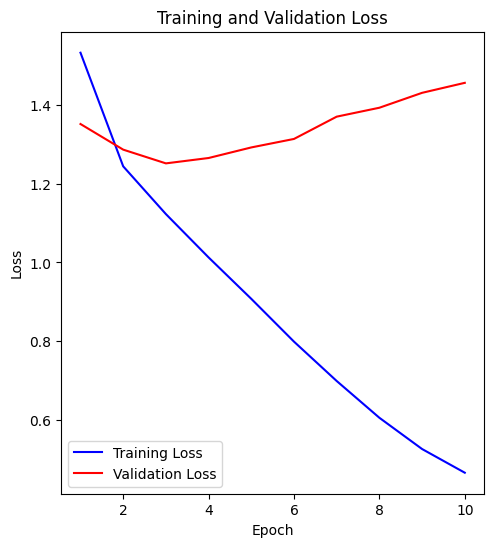

In [31]:
tcr_bert_ft.draw_stats_plot()

In [130]:
# save_model(tcr_bert_ft,"models/VJ_clf_transf/TCRbert_alfa_v.pth")

tcr_bert_ft = load_model_("models/VJ_clf_transf/TCRbert_alfa_v.pth", mod_type='TCR-bert', num_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [33]:
# tcr_bert_ft.maximun_len

27

In [133]:
tcr_bert_ft.maximun_len = 27
tcr_bert_ft.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [134]:
v_pred_labels = tcr_bert_ft.predict(v_test_dataset['cdr3aa'])
f1_sc_av = f1_score(v_ans, v_pred_labels, average='weighted')
acc_av = accuracy_score(v_ans, v_pred_labels)
print('Alpha V Genes f1_score: %.5f' % f1_sc_av)
print('Alpha V Genes accuracy: %.5f' % acc_av)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Alpha V Genes f1_score: 0.61850
Alpha V Genes accuracy: 0.62012


In [60]:
vis_df = v_genes.sample(frac=0.4, random_state=42)

hidden_states_mean = []
hidden_states_pooled = []
labels = []

tcr_bert_ft.model.eval()
tcr_bert_ft.model.to(device)

for i in tqdm(vis_df.index):
    seq, lab = vis_df.loc[i]
    encoding = tcr_bert_ft.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=27,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = tcr_bert_ft.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 10414/10414 [01:55<00:00, 90.25it/s]


In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

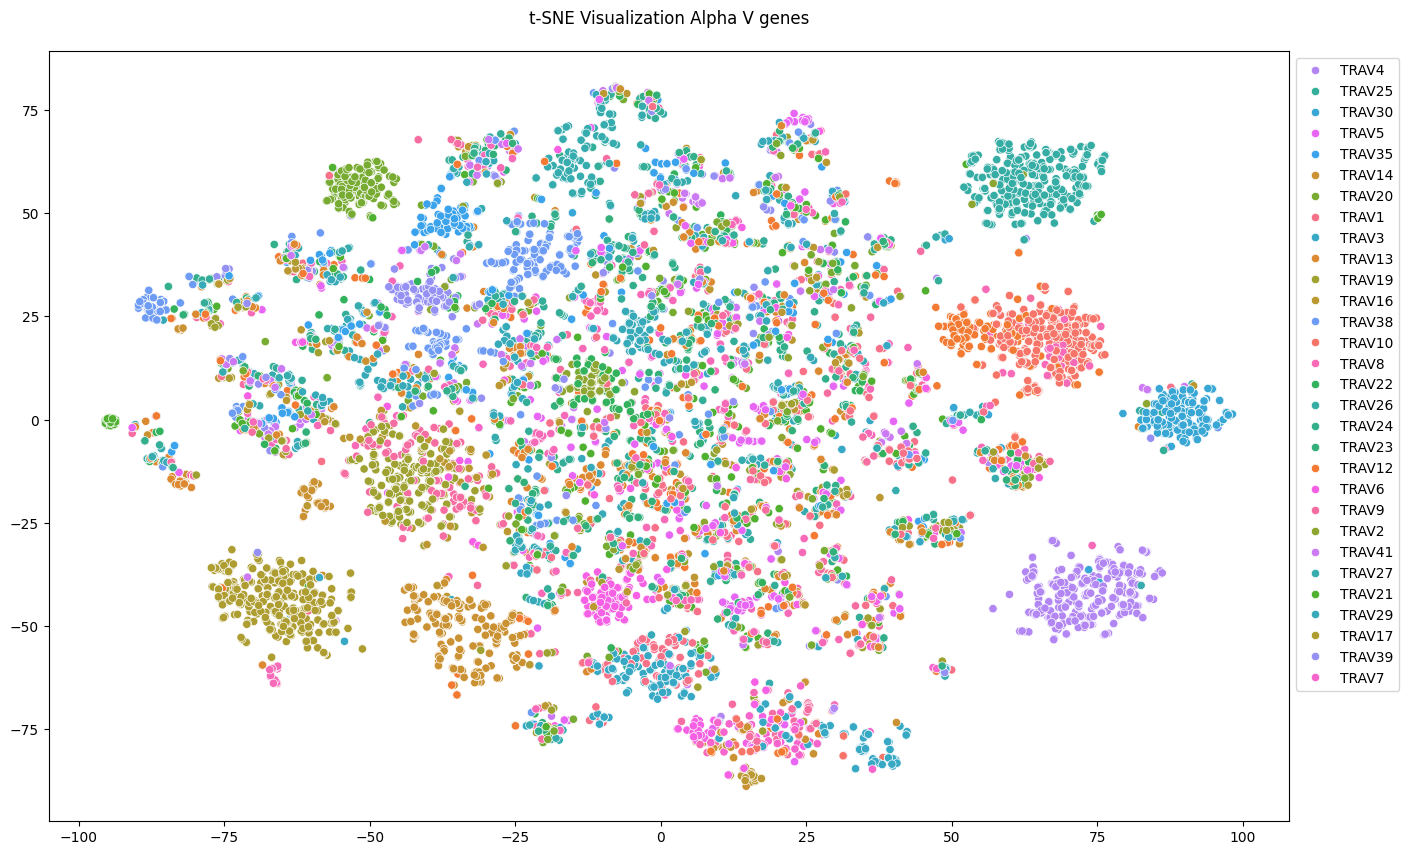

In [69]:
pca = PCA(n_components=80)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=30,  
    early_exaggeration=12,  
    learning_rate='auto',  
    n_iter=1000,  
    metric='cosine',
    init='pca',  
    random_state=42,
    n_jobs=-1, verbose=0,
)
tsne_results = tsne.fit_transform(pca_embedding)

unique_labels = np.unique(l_enc.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc.inverse_transform(labels),
    palette=color_map,
    legend="full",
    alpha=1
)

plt.title('t-SNE Visualization Alpha V genes', pad=20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)

plt.savefig('imgs/VJ_vis/Alpha_V_genes.png')

In [70]:
v_pred_genes = l_enc.inverse_transform(v_pred_labels)
v_ans_genes = l_enc.inverse_transform(list(v_ans))

In [71]:
V = mapping.keys()

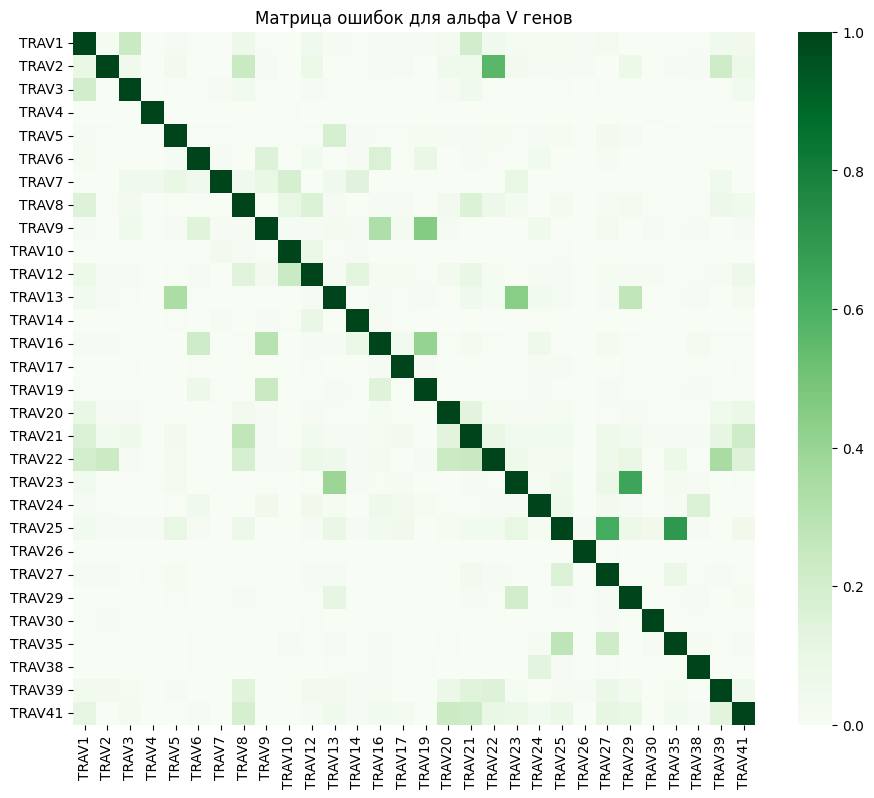

In [135]:
notm_matrix_v = draw_heatmap(v_pred_labels, v_ans, l_enc, save_dir='imgs/VJ_vis/heatmap_av.png')

# Beta V genes

In [80]:
bv = pd.read_csv('data/balanced data for clf/train_beta.csv',  usecols=['cdr3aa', 'v'])
v_genes = bv.copy()
bv_t = pd.read_csv('data/balanced data for clf/test_beta.csv',  usecols=['cdr3aa', 'v'])
v_test_dataset = bv_t.copy()

In [81]:
v_genes.v.nunique()

22

In [82]:
v_genes['cdr3aa'] = v_genes['cdr3aa'].apply(add_spaces)
v_test_dataset['cdr3aa'] = v_test_dataset['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(v_genes['v'])
v_genes['v'] = l_enc.transform(v_genes['v'])
v_test_dataset['v'] = l_enc.transform(v_test_dataset['v'])


In [83]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRBV10': 0,
 'TRBV11': 1,
 'TRBV12': 2,
 'TRBV13': 3,
 'TRBV14': 4,
 'TRBV15': 5,
 'TRBV18': 6,
 'TRBV19': 7,
 'TRBV2': 8,
 'TRBV20': 9,
 'TRBV24': 10,
 'TRBV25': 11,
 'TRBV27': 12,
 'TRBV28': 13,
 'TRBV29': 14,
 'TRBV3': 15,
 'TRBV30': 16,
 'TRBV4': 17,
 'TRBV5': 18,
 'TRBV6': 19,
 'TRBV7': 20,
 'TRBV9': 21}

In [84]:
v_genes.head()

,cdr3aa,v
0,C A T P V G D R A G G V T E A F F,10
1,C A S R V G N T E A F F,17
2,C A W K V Q G T E A F F,16
3,C A S S G D S A E T L Y F,4
4,C A R L A Y N E Q F F,0


In [85]:
v_ans = v_test_dataset['v']

v_test_dataset = v_test_dataset.drop(columns=['v'])

In [86]:
v_test_dataset.head()

,cdr3aa
0,C K R T E T G K T N Y G Y T F
1,C A T S A G T P Y T Q E T Q Y F
2,C A S S L G P G G N T E A F F
3,C A S S R D Y G Y T F
4,C A S S G R G W E T Q Y F


## Train the model

In [101]:
N_LABELS = v_genes['v'].nunique()

In [102]:
tcr_bert_ft = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [103]:
input_ids, attention_masks, labels = tcr_bert_ft.tokenize(v_genes['cdr3aa'], v_genes['v'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [104]:
train_dataset, val_dataset = tcr_bert_ft.split_data(input_ids, attention_masks, labels)

18,544 training samples
4,636 validation samples


In [105]:
tcr_bert_ft.fit(train_dataset, val_dataset, epochs=6)


======== Epoch 1 / 6 ========
Training...

  Average training loss: 1.89
  Training epcoh took: 0:00:50

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.79
  Validation took: 0:00:03

======== Epoch 2 / 6 ========
Training...

  Average training loss: 1.68
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.74
  Validation took: 0:00:03

======== Epoch 3 / 6 ========
Training...

  Average training loss: 1.56
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.73
  Validation took: 0:00:03

======== Epoch 4 / 6 ========
Training...

  Average training loss: 1.42
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.74
  Validation took: 0:00:03

======== Epoch 5 / 6 ========
Training...

  Average training loss: 1.28
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.75
  Validation took: 0:00:03

======== Epoch 6 / 

In [106]:
tcr_bert_ft.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.890594,1.789424,0.443319,0:00:50,0:00:03
2,1.680006,1.743785,0.460632,0:00:53,0:00:03
3,1.557479,1.729480,0.473994,0:00:54,0:00:03
4,1.415553,1.735545,0.478233,0:00:54,0:00:03
5,1.276157,1.750201,0.479741,0:00:49,0:00:03
6,1.152174,1.773067,0.485991,0:00:52,0:00:03


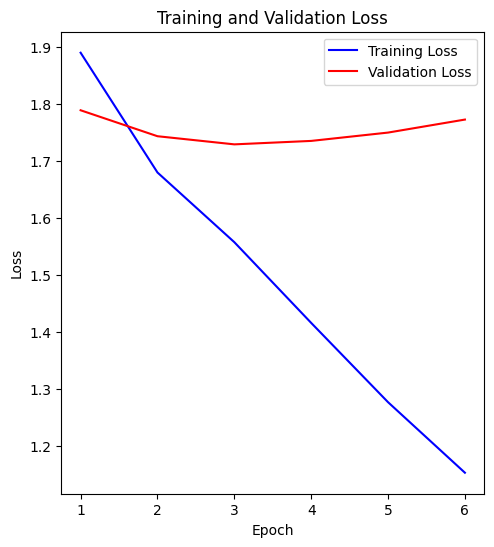

In [107]:
tcr_bert_ft.draw_stats_plot()

In [108]:
save_model(tcr_bert_ft,"models/VJ_clf_transf/TCRbert_beta_v.pth")

# tcr_bert_ft = load_model_("models/VJ_clf_transf/TCRbert_beta_v.pth", mod_type='TCR-bert', num_labels=N_LABELS)

In [109]:
tcr_bert_ft.maximun_len

30

In [110]:
v_pred_labels = tcr_bert_ft.predict(v_test_dataset['cdr3aa'])
f1_sc_bv = f1_score(v_ans, v_pred_labels, average='weighted')
acc_bv = accuracy_score(v_ans, v_pred_labels)
print('Beta V Genes f1_score: %.5f' % f1_sc_bv)
print('Beta V Genes accuracy: %.5f' % acc_bv)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Beta V Genes f1_score: 0.48310
Beta V Genes accuracy: 0.48686


In [111]:
vis_df = v_genes.sample(frac=0.4, random_state=42)

hidden_states_mean = []
hidden_states_pooled = []
labels = []

tcr_bert_ft.model.eval()
tcr_bert_ft.model.to(device)

for i in tqdm(vis_df.index):
    seq, lab = vis_df.loc[i]
    encoding = tcr_bert_ft.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=27,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = tcr_bert_ft.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:])  
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 9272/9272 [01:40<00:00, 92.48it/s]


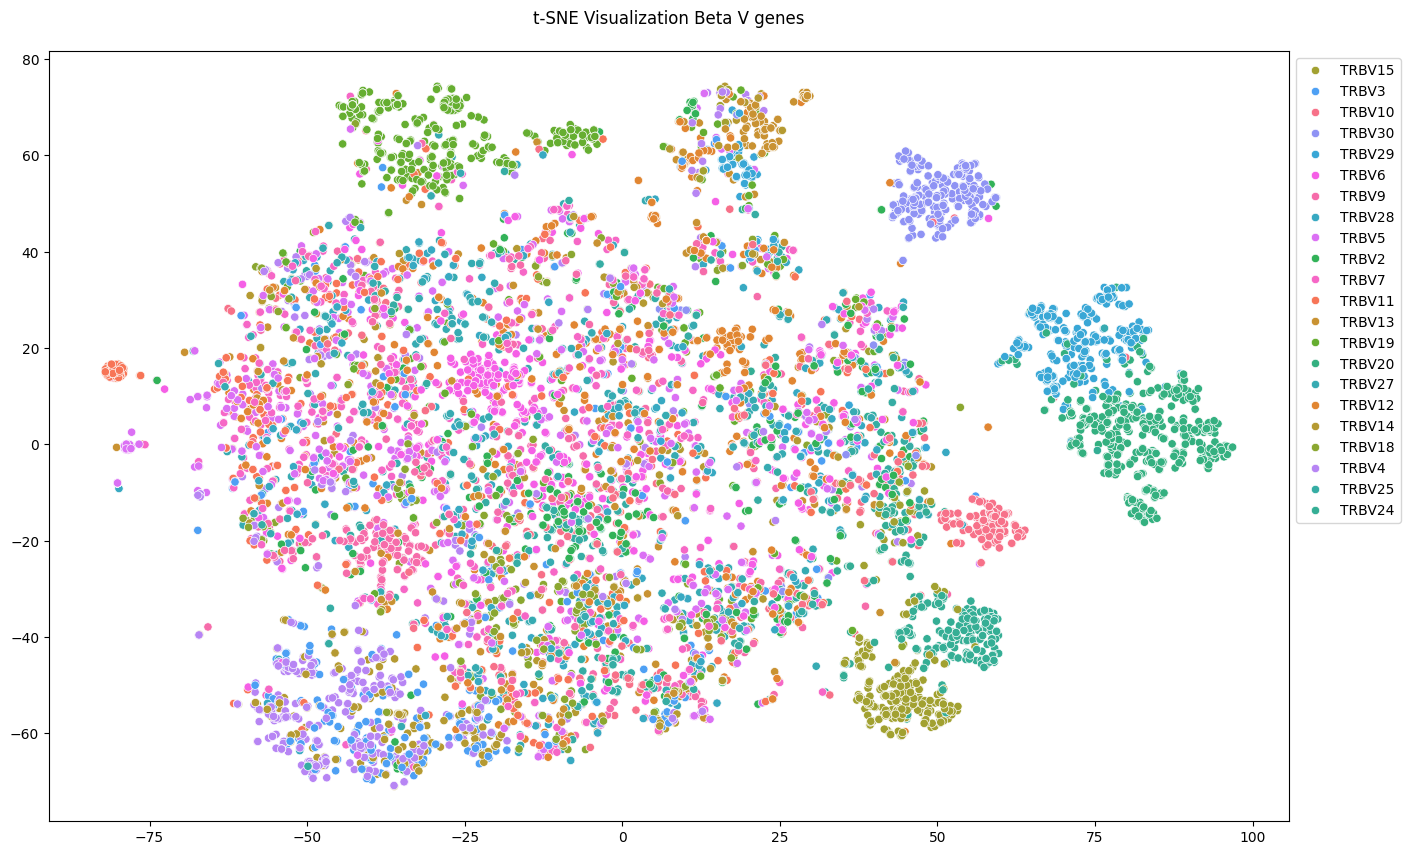

In [112]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=30,  
    early_exaggeration=12,  
    learning_rate='auto',
    n_iter=1000,  
    metric='cosine', 
    init='pca',  
    random_state=42,
    n_jobs=-1, verbose=0,
)

tsne_results = tsne.fit_transform(pca_embedding)

unique_labels = np.unique(l_enc.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc.inverse_transform(labels),
    palette=color_map,
    legend="full",
    alpha=1
)

plt.title('t-SNE Visualization Beta V genes', pad=20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)

plt.savefig('imgs/VJ_vis/Beta_V_genes.png')

In [113]:
v_pred_genes = l_enc.inverse_transform(v_pred_labels)
v_ans_genes = l_enc.inverse_transform(list(v_ans))

In [114]:
V = mapping.keys()

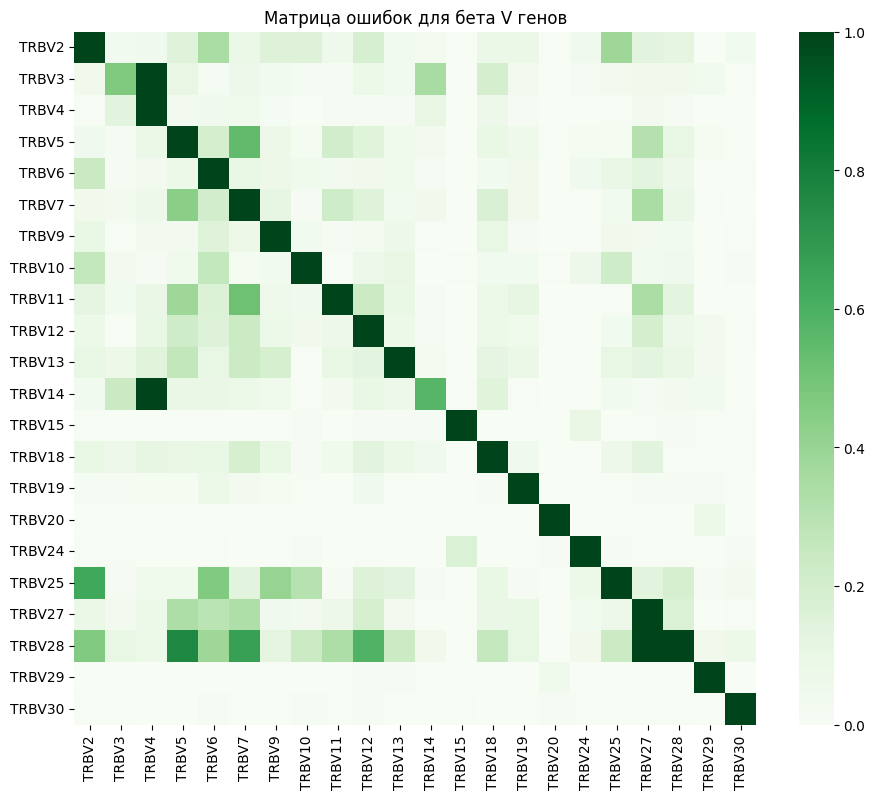

In [118]:
notm_matrix_v = draw_heatmap(v_pred_labels, v_ans, l_enc, save_dir='imgs/VJ_vis/heatmap_bv.png', label='Матрица ошибок для бета V генов')

In [79]:
from mir.common.segments import SegmentLibrary
from mir.distances import GermlineAligner

def mist_dist_heatmap(notm_matrix, gene='V'):
    lib = SegmentLibrary.load_default(genes = ['TRA', 'TRB'])
    seqs = lib.get_seqaas('TRA', gene)
    seqs.extend(lib.get_seqaas('TRB', gene))
    v_seqs_0 = {process_types(i[0]):i[1] for i in seqs}
    v_seqs = {i[0]:i[1] for i in seqs}
    
    v_seqs = list(v_seqs.keys())
    
    classes0 = v_seqs_0
    classes = v_seqs
    galn = GermlineAligner.from_seqs(seqs)



    dist_matr = pd.DataFrame(data = 0, columns=classes0, index= classes0)
    for i in range(len(classes)):
        for j in range(len(classes)):
            try:
                score_norm = galn.score_norm(v_seqs[i], v_seqs[j])
                dist_matr.loc[process_types(classes[i]), process_types(classes[j])] = -score_norm
            except KeyError:
                pass
            
    dist_matr_norm = MinMaxScaler().fit_transform(1-dist_matr) 
    dist_matr_norm = pd.DataFrame(data = dist_matr_norm, columns= classes0, index= classes0)

    inters = notm_matrix.index.intersection(dist_matr_norm.index)
    m1 = notm_matrix.loc[inters, inters]/dist_matr_norm.loc[inters, inters]
    m1 = m1.fillna(0)

    
    m1_norm = norm(m1)#MinMaxScaler().fit_transform(m1)
    fig, ax = plt.subplots(figsize=(11,9)) 
    sns.heatmap(m1_norm, cmap="Greens")
    

        

    
    
    

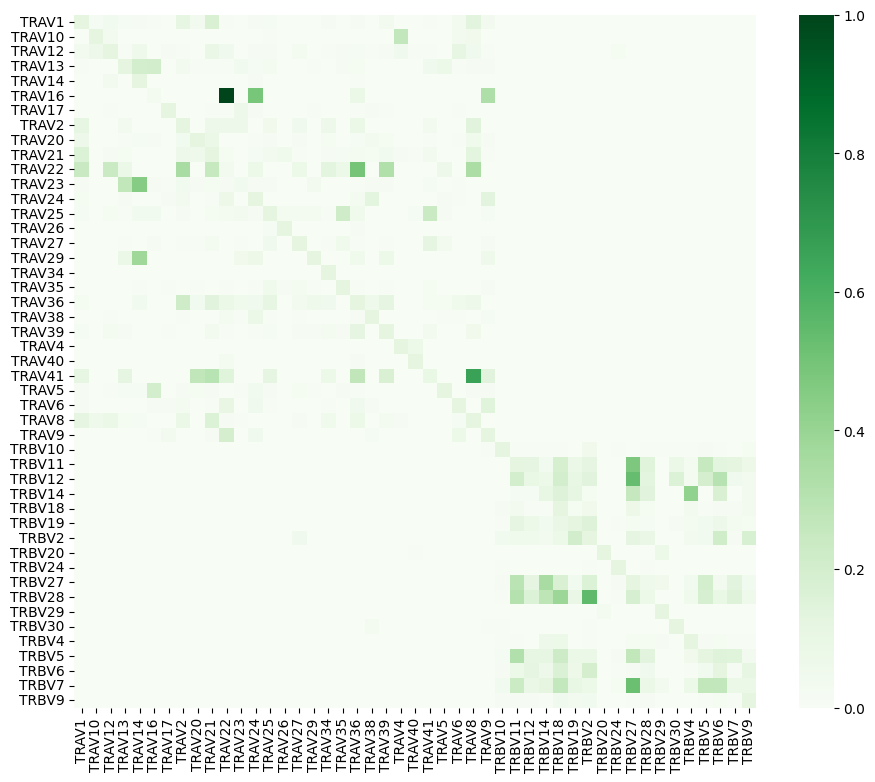

In [73]:
mist_dist_heatmap(notm_matrix_v) 

### Prottrans

In [76]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(v_resampled, test_size=0.2, random_state=42)

In [77]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'v': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'v': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
20014,C A S S N T G G Y G Y T F,34
5676,C A L S S F S G G Y N K L I F,28
11462,C A S S Q W P G T Y N E Q F F,46
27146,C A G Q L I Y D Y K L S F,18
428,C A F A G S N Y K L T F,12
...,...,...
15336,C A V R G G R S W G K L Q F,9
10063,C A T S D R R S G G Y T F,38
24188,C A V G P R E R T G G Y Q K V T F,0
8193,C A V A N D A G N M L T F,21


In [78]:
N_LABELS = len(v_resampled.v.value_counts())

tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, batch=8, accum=8, epochs=10, seed=42)

loading configuration file config.json from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--p

ProtT5_Classfier
Trainable Parameter: 1209240624
ProtT5_LoRA_Classfier
Trainable Parameter: 3606576



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


[2024-09-05 01:58:54,480] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-09-05 01:58:55,825] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabli

Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ninja: no work to do.
Time to load cpu_adam op: 4.75648832321167 seconds


Loading extension module cpu_adam...


[2024-09-05 01:59:10,201] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-09-05 01:59:10,202] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-09-05 01:59:10,257] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-09-05 01:59:10,259] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-09-05 01:59:10,260] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-09-05 01:59:10,261] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-09-05 01:59:10,262] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-09-05 01:59:10,262] [INFO] [stage_1_and_2.py:151:__init__] CPU Offload: True
[2024-09-05 01:59:10,263] [INFO] [stage_1_and_2.py:1

***** Running training *****
  Num examples = 22460
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 3510
  Number of trainable parameters = 3606576


Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [ ]:
my_test=v_test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test.head(5)

In [ ]:
# #save_model(model,"./models_ft/Prottrans_v_genes_finetuned.pth")
N_LABELS = len(v_resampled.v.value_counts())
tokenizer_, model_reload = load_model_("./models_ft/Prottrans_v_genes_finetuned.pth", num_labels=N_LABELS, mixed=False)

In [ ]:
test_set=create_dataset(tokenizer_, list(my_test['sequence']),list(v_ans))

test_set = test_set.with_format("torch", device=device)

test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

model_reload.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        predictions += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()


In [ ]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(v_ans), predictions, average='macro'))

In [ ]:
wrond_ans = v_ans[v_ans != predictions].index

# Alpha J genes

In [136]:
aj = pd.read_csv('data/balanced data for clf/train_alpha.csv', usecols=['cdr3aa', 'j'])
aj

,cdr3aa,j
0,CAAIGGSTLGRLYF,TRAJ18
1,CAASFSGYSTLTF,TRAJ11
2,CALGDGGNYQLIW,TRAJ33
3,CALFDFGNEKLTF,TRAJ48
4,CAGSKNAGKSTF,TRAJ27
...,...,...
26029,CAVLPLYGGSQGNLIF,TRAJ42
26030,CAEIPNYGGSQGNLIF,TRAJ42
26031,CAMRDYNVLYF,TRAJ21
26032,CLVAVPADTGRRALTF,TRAJ5


In [137]:
j_genes = aj.copy()

In [138]:
aj_t = pd.read_csv('data/balanced data for clf/test_alpha.csv', usecols=['cdr3aa', 'j'])
j_test_dataset = aj_t.copy()

In [139]:
j_genes.j.nunique()

46

In [141]:
j_genes['cdr3aa'] = j_genes['cdr3aa'].apply(add_spaces)
j_test_dataset['cdr3aa'] = j_test_dataset['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(j_genes['j'])
j_genes['j'] = l_enc.transform(j_genes['j'])
j_test_dataset['j'] = l_enc.transform(j_test_dataset['j'])


In [142]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRAJ10': 0,
 'TRAJ11': 1,
 'TRAJ12': 2,
 'TRAJ13': 3,
 'TRAJ15': 4,
 'TRAJ16': 5,
 'TRAJ17': 6,
 'TRAJ18': 7,
 'TRAJ20': 8,
 'TRAJ21': 9,
 'TRAJ22': 10,
 'TRAJ23': 11,
 'TRAJ24': 12,
 'TRAJ26': 13,
 'TRAJ27': 14,
 'TRAJ28': 15,
 'TRAJ29': 16,
 'TRAJ3': 17,
 'TRAJ30': 18,
 'TRAJ31': 19,
 'TRAJ32': 20,
 'TRAJ33': 21,
 'TRAJ34': 22,
 'TRAJ36': 23,
 'TRAJ37': 24,
 'TRAJ39': 25,
 'TRAJ4': 26,
 'TRAJ40': 27,
 'TRAJ41': 28,
 'TRAJ42': 29,
 'TRAJ43': 30,
 'TRAJ44': 31,
 'TRAJ45': 32,
 'TRAJ47': 33,
 'TRAJ48': 34,
 'TRAJ49': 35,
 'TRAJ5': 36,
 'TRAJ50': 37,
 'TRAJ52': 38,
 'TRAJ53': 39,
 'TRAJ54': 40,
 'TRAJ56': 41,
 'TRAJ57': 42,
 'TRAJ6': 43,
 'TRAJ8': 44,
 'TRAJ9': 45}

In [143]:
j_genes.head()

,cdr3aa,j
0,C A A I G G S T L G R L ...,7
1,C A A S F S G Y S T L T F,1
2,C A L G D G G N Y Q L I W,21
3,C A L F D F G N E K L T F,34
4,C A G S K N A G K S T F,14


In [144]:
j_ans = j_test_dataset['j']

j_test_dataset = j_test_dataset.drop(columns=['j'])

In [145]:
j_test_dataset.head()

,cdr3aa
0,C A Y R V D N A R L M F
1,C A T D G D T P L V F
2,C A T D D S S A S K I I F
3,C I L R G F G N E K L T F
4,C A V R D S N Y Q L I W


## Train the model

### TCR-bert

In [146]:
N_LABELS = j_genes['j'].nunique()

In [147]:
tcr_bert_ft = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [148]:
input_ids, attention_masks, labels = tcr_bert_ft.tokenize(j_genes['cdr3aa'], j_genes['j'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [149]:
train_dataset, val_dataset = tcr_bert_ft.split_data(input_ids, attention_masks, labels)

20,827 training samples
5,207 validation samples


In [150]:
tcr_bert_ft.fit(train_dataset, val_dataset, epochs=10)


======== Epoch 1 / 10 ========
Training...

  Average training loss: 0.25
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 2 / 10 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 3 / 10 ========
Training...

  Average training loss: 0.02
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:01:00

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch

In [151]:
tcr_bert_ft.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.247018,0.047312,0.992140,0:01:02,0:00:04
2,0.028799,0.048623,0.992715,0:01:00,0:00:04
3,0.019169,0.045246,0.992331,0:00:59,0:00:04
4,0.014471,0.046867,0.992331,0:01:01,0:00:04
5,0.011163,0.053636,0.991564,0:01:00,0:00:04
6,0.009726,0.051367,0.992140,0:01:01,0:00:04
7,0.008365,0.053842,0.992331,0:01:01,0:00:04
8,0.006905,0.050381,0.992331,0:01:01,0:00:04
9,0.006053,0.051224,0.991948,0:01:01,0:00:04


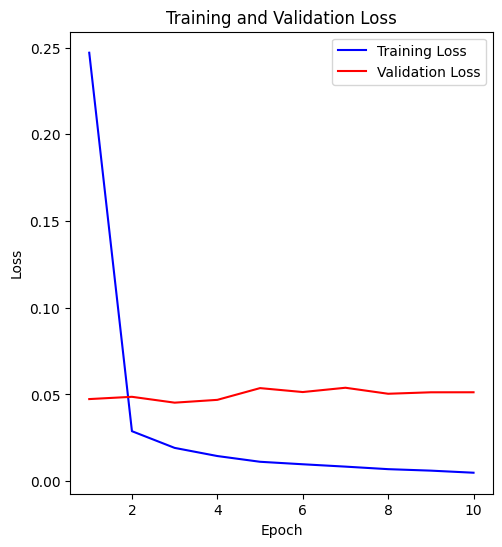

In [152]:
tcr_bert_ft.draw_stats_plot()

In [153]:
save_model(tcr_bert_ft,"models/VJ_clf_transf/TCRbert_alfa_j.pth")

# tcr_bert_ft = load_model_("models/VJ_clf_transf/TCRbert_alfa_j.pth", mod_type='TCR-bert', num_labels=N_LABELS)

In [154]:
tcr_bert_ft.maximun_len

27

In [155]:
# my_model_reload.to(device)
j_pred_labels = tcr_bert_ft.predict(j_test_dataset['cdr3aa'])
f1_sc_aj = f1_score(j_ans, j_pred_labels, average='weighted')
acc_aj = accuracy_score(j_ans, j_pred_labels)
print('Alpha J Genes f1_score: %.5f' % f1_sc_aj)
print('Alpha J Genes accuracy: %.5f' % acc_aj)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Alpha J Genes f1_score: 0.99298
Alpha J Genes accuracy: 0.99297


In [156]:
vis_df = j_genes.sample(frac=0.4, random_state=42)

hidden_states_mean = []
hidden_states_pooled = []
labels = []

tcr_bert_ft.model.eval()
tcr_bert_ft.model.to(device)

for i in tqdm(vis_df.index):
    seq, lab = vis_df.loc[i]
    encoding = tcr_bert_ft.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=27,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = tcr_bert_ft.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    

    last_n_layers = torch.stack(outputs.hidden_states[-4:])  
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 10414/10414 [01:53<00:00, 92.01it/s]


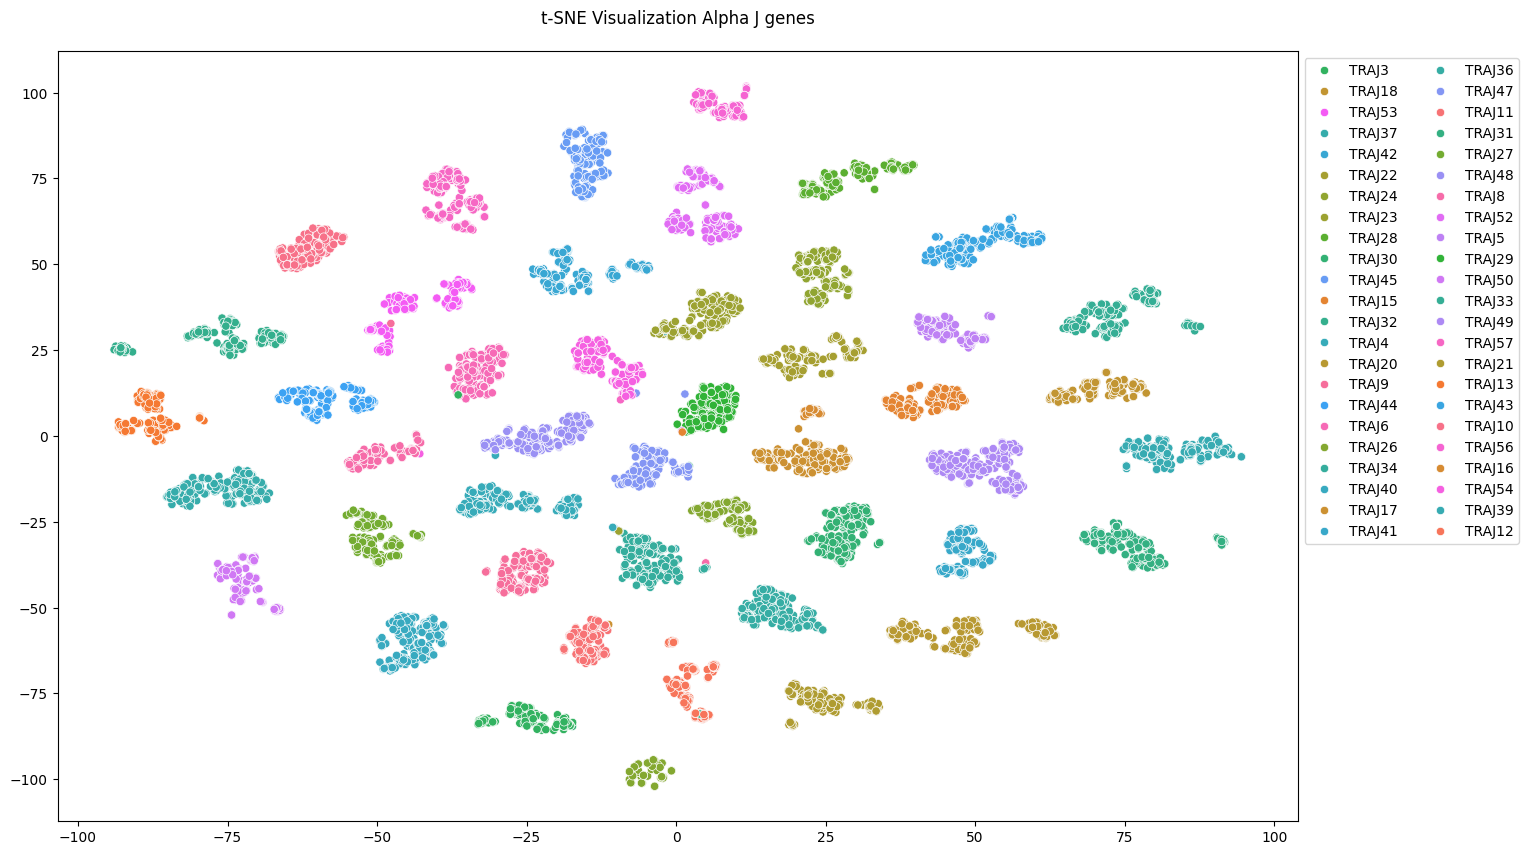

In [163]:
pca = PCA(n_components=80)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=30, 
    early_exaggeration=12,  
    learning_rate='auto',  
    n_iter=1000,  
    metric='cosine',
    init='pca',  
    random_state=42,
    n_jobs=-1, verbose=0,
)

tsne_results = tsne.fit_transform(pca_embedding)

unique_labels = np.unique(l_enc.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc.inverse_transform(labels),
    palette=color_map,
    legend="full",
    alpha=1
)

plt.title('t-SNE Visualization Alpha J genes', pad=20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)

plt.savefig('imgs/VJ_vis/Alpha_J_genes.png', bbox_inches='tight')

In [158]:
j_pred_genes = l_enc.inverse_transform(j_pred_labels)
j_ans_genes = l_enc.inverse_transform(list(j_ans))

In [159]:
J = mapping.keys()

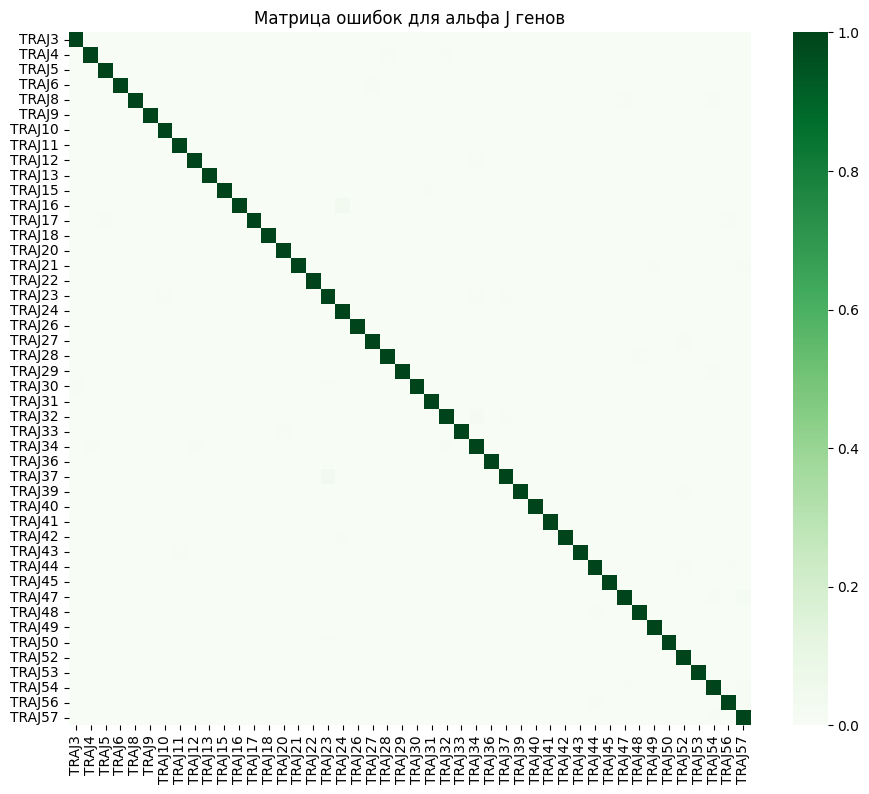

In [160]:
notm_matrix_j = draw_heatmap(j_pred_labels, j_ans, l_enc, save_dir='imgs/VJ_vis/heatmap_aj.png', label = 'Матрица ошибок для альфа J генов')

# Beta J genes

In [164]:
bj = pd.read_csv('data/balanced data for clf/train_beta.csv', usecols=['cdr3aa', 'j'])
j_genes = bj.copy()

bj_t = pd.read_csv('data/balanced data for clf/test_beta.csv', usecols=['cdr3aa', 'j'])
j_test_dataset = bj_t.copy()

j_genes.j.nunique()

2

In [165]:
j_genes['cdr3aa'] = j_genes['cdr3aa'].apply(add_spaces)
j_test_dataset['cdr3aa'] = j_test_dataset['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(j_genes['j'])
j_genes['j'] = l_enc.transform(j_genes['j'])
j_test_dataset['j'] = l_enc.transform(j_test_dataset['j'])


In [166]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRBJ1': 0, 'TRBJ2': 1}

In [167]:
j_genes.head()

,cdr3aa,j
0,C A T P V G D R A G G V T E A F F,0
1,C A S R V G N T E A F F,0
2,C A W K V Q G T E A F F,0
3,C A S S G D S A E T L Y F,1
4,C A R L A Y N E Q F F,1


In [168]:
j_ans = j_test_dataset['j']

j_test_dataset = j_test_dataset.drop(columns=['j'])

In [169]:
j_test_dataset.head()

,cdr3aa
0,C K R T E T G K T N Y G Y T F
1,C A T S A G T P Y T Q E T Q Y F
2,C A S S L G P G G N T E A F F
3,C A S S R D Y G Y T F
4,C A S S G R G W E T Q Y F


## Train the model

### TCR-bert

In [170]:
N_LABELS = j_genes['j'].nunique()

In [171]:
tcr_bert_ft = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [172]:
input_ids, attention_masks, labels = tcr_bert_ft.tokenize(j_genes['cdr3aa'], j_genes['j'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [173]:
train_dataset, val_dataset = tcr_bert_ft.split_data(input_ids, attention_masks, labels)

18,544 training samples
4,636 validation samples


In [174]:
tcr_bert_ft.fit(train_dataset, val_dataset, epochs=5)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.02
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:00:03

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.02
  Validation took: 0:00:03

Training complete!


In [175]:
tcr_bert_ft.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.031199,0.010676,0.997198,0:00:54,0:00:03
2,0.011717,0.009077,0.997414,0:00:54,0:00:03
3,0.008162,0.015328,0.996983,0:00:54,0:00:03
4,0.005097,0.014974,0.997845,0:00:54,0:00:03
5,0.001976,0.016024,0.997414,0:00:54,0:00:03


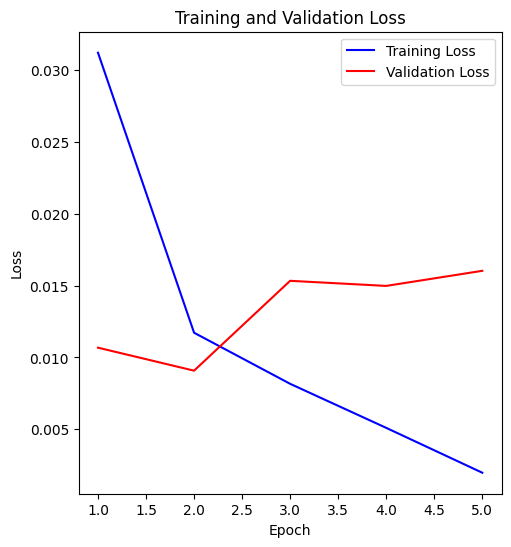

In [176]:
tcr_bert_ft.draw_stats_plot()

In [177]:
save_model(tcr_bert_ft,"models/VJ_clf_transf/TCRbert_beta_j.pth")

# tcr_bert_ft = load_model_("models/VJ_clf_transf/TCRbert_beta_j.pth", mod_type='TCR-bert', num_labels=N_LABELS)

In [178]:
tcr_bert_ft.maximun_len

30

In [179]:
j_pred_labels = tcr_bert_ft.predict(j_test_dataset['cdr3aa'])
f1_sc_bj = f1_score(j_ans, j_pred_labels, average='weighted')
acc_bj = accuracy_score(j_ans, j_pred_labels)
print('Alpha J Genes f1_score: %.5f' % f1_sc_bj)
print('Alpha J Genes accuracy: %.5f' % acc_bj)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Alpha J Genes f1_score: 0.99741
Alpha J Genes accuracy: 0.99741


In [180]:
vis_df = j_genes.sample(frac=0.4, random_state=42)

hidden_states_mean = []
hidden_states_pooled = []
labels = []

tcr_bert_ft.model.eval()
tcr_bert_ft.model.to(device)

for i in tqdm(vis_df.index):
    seq, lab = vis_df.loc[i]
    encoding = tcr_bert_ft.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=27,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = tcr_bert_ft.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:])  
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1)) 
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 9272/9272 [01:40<00:00, 92.03it/s]


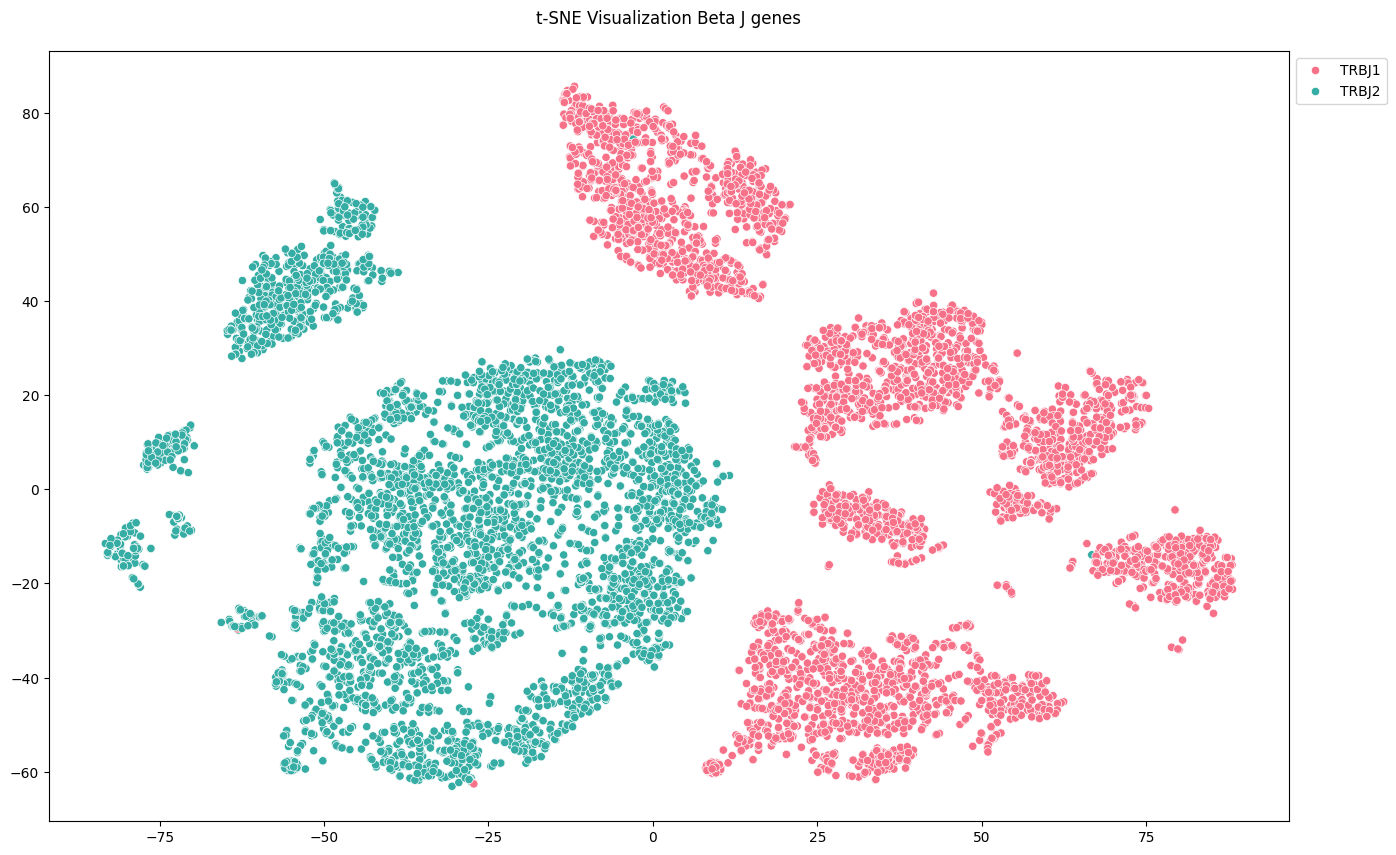

In [181]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=30, 
    early_exaggeration=12,  
    learning_rate='auto',  
    n_iter=1000,  
    metric='cosine',
    init='pca',  
    random_state=42,
    n_jobs=-1, verbose=0,
)
tsne_results = tsne.fit_transform(pca_embedding)

unique_labels = np.unique(l_enc.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc.inverse_transform(labels),
    palette=color_map,
    legend="full",
    alpha=1
)

plt.title('t-SNE Visualization Beta J genes', pad=20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)

plt.savefig('imgs/VJ_vis/Beta_J_genes.png')

In [182]:
j_pred_genes = l_enc.inverse_transform(j_pred_labels)
j_ans_genes = l_enc.inverse_transform(list(j_ans))

In [183]:
J = mapping.keys()

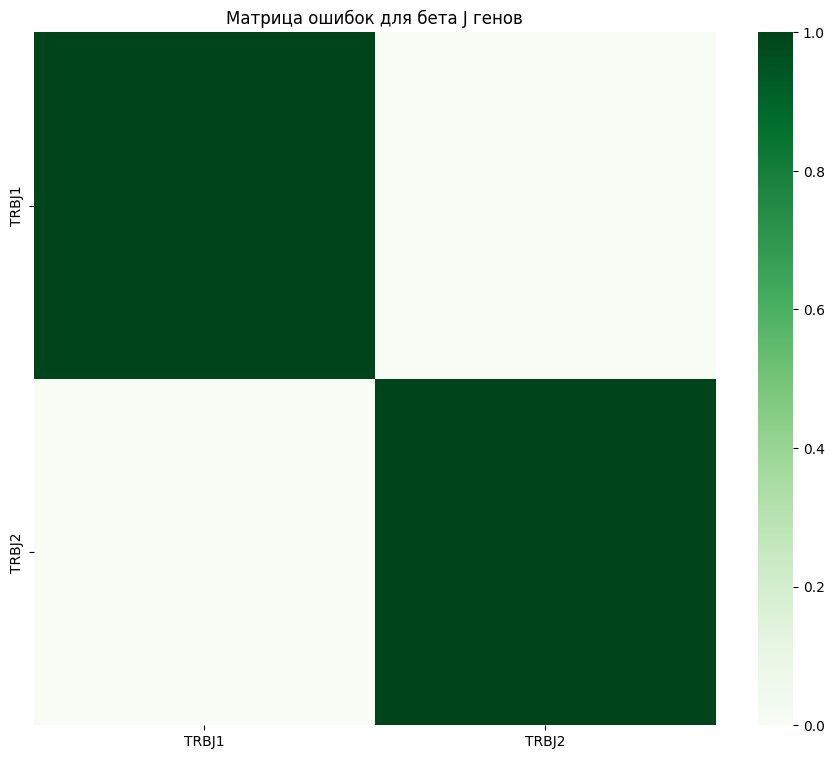

In [184]:
notm_matrix_j = draw_heatmap(j_pred_labels, j_ans, l_enc, save_dir='imgs/VJ_vis/heatmap_bj.png', label = 'Матрица ошибок для бета J генов')

### Prottrans

In [100]:
j_train_df, j_val_df = train_test_split(j_resampled, test_size=0.2, random_state=42)

In [176]:
j_train_df = j_train_df.rename({'cdr3aa': 'sequence', 'j': 'label'}, axis=1)
j_val_df = j_val_df.rename({'cdr3aa': 'sequence', 'j': 'label'}, axis=1)
j_train_df["sequence"] = j_train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
j_val_df["sequence"] = j_val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
j_val_df

,sequence,label
18398,C A V E S S N F G N E K L T F,28
11773,C A T G R S S N T G K L I F,19
12876,C A S S V T G G L R T N E Q F F,40
12256,C A V P S S G N T P L V F,13
16515,C A A F T G G G N K L T F,0
...,...,...
4325,C A E N L E P R G K L I F,6
13054,C A V S G A G N Q F Y F,29
16259,C A E R I T G G G N K L T F,0
11206,C A E G T P S N T G K L I F,19


In [101]:
N_LABELS = len(j_resampled.j.value_counts())

j_tokenizer, j_model, j_history = train_per_protein(j_train_df, j_val_df, num_labels=N_LABELS, batch=8, accum=8, epochs=5, seed=42)

In [178]:
my_test_j=j_test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test_j["sequence"]=my_test_j["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test_j.head(5)

,sequence
0,C A E S S G G S Y I P T F
1,C A S S R A A G Q G V S Y N S P L H F
2,C A G R A N F G N E K L T F
3,C A A S A R S G Y A L N F
4,C A A N P G A N N L F F


In [179]:
# create Dataset
test_set=create_dataset(j_tokenizer, list(my_test_j['sequence']),list(j_ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


j_model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += j_model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 296/296 [00:20<00:00, 14.18it/s]


In [180]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(j_ans), predictions, average='macro'))

F1 score:  0.8038587413923719


In [40]:
N_LABELS = len(j_resampled.j.value_counts())

#save_model(j_model,"./Prottrans_j_genes_finetuned.pth")
tokenizer_1, model_reload = load_model_("./Prottrans_j_genes_finetuned.pth", num_labels=N_LABELS, mixed=False)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.16.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.15.layer.1.layer_norm.weight', 'decoder.block.23.layer.1.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.12.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.2.DenseReluDense.wi.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.o.weight', 'decoder.block.12.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.0.layer_nor

ProtT5_Classfier
Trainable Parameter: 1209233449
ProtT5_LoRA_Classfier
Trainable Parameter: 3599401

